## BBC News Classification
## 0. General information

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:


The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

💡Getting Started Notebook
To get started quickly, feel free to take advantage of this starter notebook.

Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480


source:
https://www.kaggle.com/competitions/nlp-getting-started/overview


## 1.  Brief description of the problem and data (5 pts) 


Submissions are evaluated using F1 between the predicted and expected answers.

F1 is calculated as follows:
F1=2∗precision∗recallprecision+recall

where:

precision=TPTP+FP

recall=TPTP+FN

and:

- True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.


#### Dataset Description

You'll need train.csv, test.csv and sample_submission.csv.

What should I expect the data format to be?
Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
Files
3 files

Size
1.43 MB

Type
csv

License


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


#sets the default autosave frequency in seconds
%autosave 60

%matplotlib inline

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import datasets

Autosaving every 60 seconds


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In [3]:
random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)


train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [4]:
print("Train set size:", train_data.shape)
print("Test set size:", test_data.shape)

Train set size: (7613, 5)
Test set size: (3263, 4)


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [12]:
print("\nTest set preview:")
print(test_data.head())

print("\nTest set statistics:")
print(test_data.describe(include='all'))

print("\nMissing values in test set:")
print(test_data.isnull().sum())


Test set preview:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

Test set statistics:
             id  keyword  location                                               text
count   3263.00     3237      2158                                               3263
unique      NaN      221      1602                                               3243
top         NaN  deluged  New York  11-Year-Old Boy Charged With Manslaughter of T...
freq        NaN       23        38                                                  3
mean    5427.15      NaN       NaN                                                NaN

In [13]:
print("\nTrain set preview:")
print(train_data.head())

print("\nTrain set statistics:")
print(train_data.describe(include='all'))

print("\nMissing values in train set:")
print(train_data.isnull().sum())


Train set preview:
   id keyword location                                               text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1

Train set statistics:
             id     keyword location                                               text  target
count   7613.00        7552     5080                                               7613 7613.00
unique      NaN         221     3341                                               7503     NaN
top         NaN  fatalities      USA  11-Year-Old Boy Charged With Manslaughter of T...     NaN
freq        NaN          45      104                                             

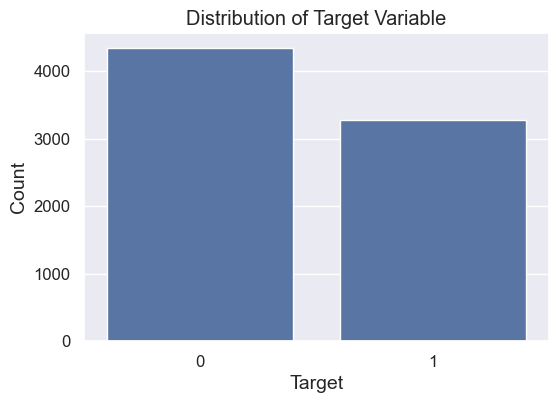

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
print(train_data.columns)
print()
print(train_data.target.value_counts())
print()
print(train_data["text"])

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

target
0    4342
1    3271
Name: count, dtype: int64

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object


Average Length: 101.03743596479706
Minimum Length: 7
Maximum Length: 157


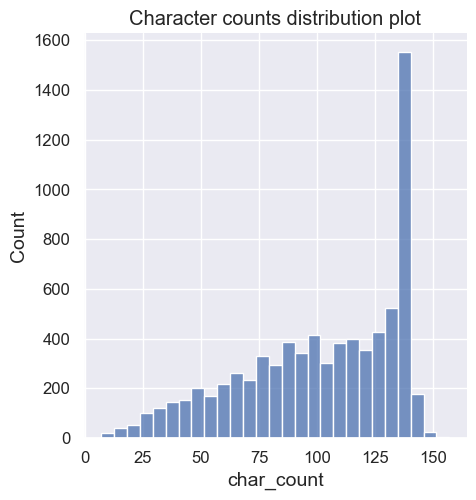

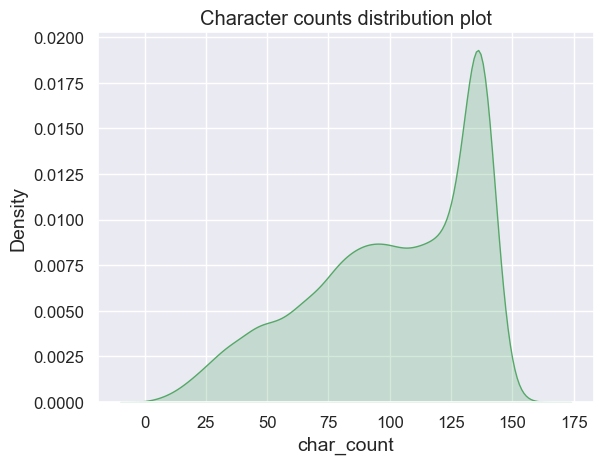

In [22]:
train_data['char_count'] = train_data['text'].apply(len)
average_length = train_data['char_count'].mean()
min_length = train_data['char_count'].min()
max_length = train_data['char_count'].max()


print(f'Average Length: {average_length}')
print(f'Minimum Length: {min_length}')
print(f'Maximum Length: {max_length}')

sns.displot(train_data['char_count'])
plt.title("Character counts distribution plot")
plt.show()

sns.kdeplot(train_data['char_count'], color='g', fill=True)
plt.title("Character counts distribution plot")
plt.show()

most common words
[('t', 5199), ('co', 4740), ('http', 4309), ('the', 3277), ('a', 2200), ('in', 1986), ('to', 1949), ('of', 1830), ('i', 1778), ('and', 1426), ('is', 950), ('s', 910)]
lest common words
[('ymy4rskq3d', 1), ('stfmbbzfb5', 1), ('nf4iculoje', 1), ('rqkk15uhey', 1), ('symptoms', 1), ('developing', 1), ('forney', 1), ('5uecmcv2pk', 1), ('9km', 1), ('fa3fcnln86', 1)]


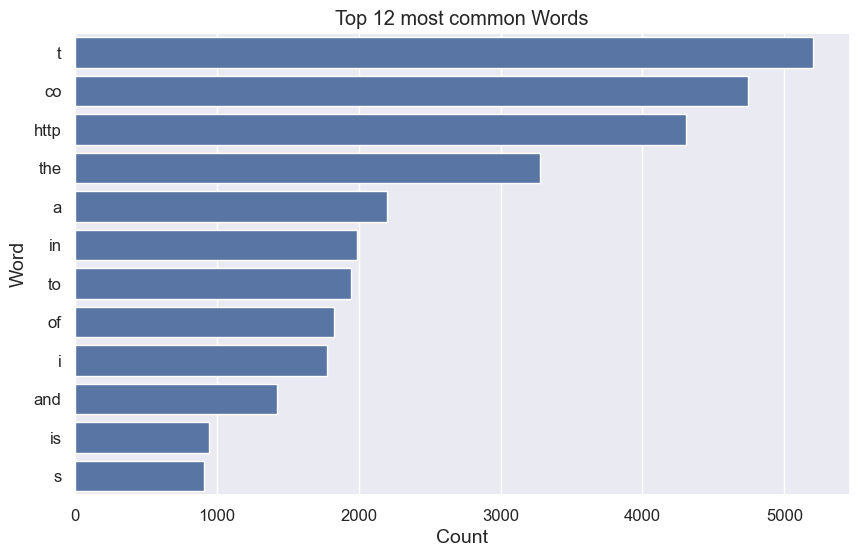

In [25]:
all_text = ' '.join(train_data['text'].astype(str))
words = re.findall(r'\b\w+\b', all_text.lower())
word_counts = Counter(words)
total_words = sum(word_counts.values())
most_common_words = word_counts.most_common(12)
print("most common words")
print(most_common_words)
least_common_words = word_counts.most_common()[:-11:-1]
print("lest common words")
print(least_common_words)

df_most_common = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_most_common, x='Count', y='Word')

plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 12 most common Words')

plt.show()

In [26]:
# clean
print("Cleaning")

train_data['keyword'].fillna('missing_keyword', inplace=True)
train_data['location'].fillna('missing_location', inplace=True)
test_data['keyword'].fillna('missing_keyword', inplace=True)
test_data['location'].fillna('missing_location', inplace=True)

train_data.isnull().sum()
test_data.isnull().sum()



Cleaning


C:\Users\amarq\AppData\Local\Temp\ipykernel_24612\2823111919.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('missing_keyword', inplace=True)
C:\Users\amarq\AppData\Local\Temp\ipykernel_24612\2823111919.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

id          0
keyword     0
location    0
text        0
dtype: int64

In [30]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)


print("\nCleaned text preview in train set:")
print(train_data[['text', 'clean_text']].head())

print("\nCleaned text preview in test set:")
print(test_data[['text', 'clean_text']].head())

all_clean_text = ' '.join(train_data['clean_text'].astype(str))
train_data['combined_text'] = train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['clean_text']
test_data['combined_text'] = test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['clean_text']

train_data['combined_text']

test_data['combined_text']




Cleaned text preview in train set:
                                                text                                         clean_text
0  Our Deeds are the Reason of this #earthquake M...  our deeds are the reason of this earthquake ma...
1             Forest fire near La Ronge Sask. Canada              forest fire near la ronge sask canada
2  All residents asked to 'shelter in place' are ...  all residents asked to shelter in place are be...
3  13,000 people receive #wildfires evacuation or...  people receive wildfires evacuation orders in ...
4  Just got sent this photo from Ruby #Alaska as ...  just got sent this photo from ruby alaska as s...

Cleaned text preview in test set:
                                                text                                         clean_text
0                 Just happened a terrible car crash                 just happened a terrible car crash
1  Heard about #earthquake is different cities, s...  heard about earthquake is different cities 

0       missing_keyword missing_location just happened...
1       missing_keyword missing_location heard about e...
2       missing_keyword missing_location there is a fo...
3       missing_keyword missing_location apocalypse li...
4       missing_keyword missing_location typhoon soude...
                              ...                        
3258    missing_keyword missing_location earthquake sa...
3259    missing_keyword missing_location storm in ri w...
3260    missing_keyword missing_location green line de...
3261    missing_keyword missing_location meg issues ha...
3262    missing_keyword missing_location cityofcalgary...
Name: combined_text, Length: 3263, dtype: object

## 3. DModel Architecture (25 pts)

The three main architectures employed to tackle this problem are:

- **Logistic Regression**: A linear and interpretable model, particularly advantageous for processing large datasets and sparse data efficiently.  
- **TF-IDF Vectorizer**: Converts text into numerical features by evaluating word importance, effectively managing high-dimensionality while capturing contextual meaning through n-grams.  
- **Model Justification**: The synergy of Logistic Regression and TF-IDF Vectorization proves highly effective due to their scalability, interpretability, and capability to handle sparse, high-dimensional text data.


The integration of TF-IDF Vectorizer and Logistic Regression is particularly effective for addressing text classification challenges. This combination excels in managing sparse, high-dimensional data while maintaining the interpretability of the model. As a robust baseline, this architecture provides a reliable foundation for the task. If performance improvements are desired, exploring advanced approaches such as ensemble techniques or deep learning models could be worthwhile.


code......

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data['combined_text'])
X_test = vectorizer.transform(test_data['combined_text'])
y_train = train_data['target']
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=2100)
model.fit(X_train_split, y_train_split)
#LogisticRegression(max_iter=2100)



Shape of X_train: (7613, 10000)
Shape of X_test: (3263, 10000)


LogisticRegression(max_iter=2100)

In [34]:
y_val_pred = model.predict(X_val)
print(accuracy_score(y_val, y_val_pred))
print( classification_report(y_val, y_val_pred))

0.799080761654629
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       874
           1       0.81      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



At this point using logistic regression we have a accuracy of 0.799080761654629
Let’s try other methods: Hyperparameter Tuning


In [37]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],'penalty': ['l1', 'l2'],'solver': ['liblinear']}
log_reg = LogisticRegression(max_iter=2100)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)
#LogisticRegression(C=1, max_iter=2100, solver='liblinear')
#LogisticRegression(C=1, max_iter=2100, solver='liblinear')
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.7973727422003284


In [38]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_model = SVC(C=1, kernel='linear', random_state=42)
nb_model = MultinomialNB()

# Train and evaluate models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Machine': svm_model,
    'Multinomial Naive Bayes': nb_model
}

for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {accuracy}")
    print(f"\nClassification Report for {name}:\n", classification_report(y_val, y_val_pred))

Random Forest Validation Accuracy: 0.7760998030203545

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.90      0.82       874
           1       0.82      0.61      0.70       649

    accuracy                           0.78      1523
   macro avg       0.79      0.75      0.76      1523
weighted avg       0.78      0.78      0.77      1523

Gradient Boosting Validation Accuracy: 0.7314510833880499

Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.71      0.89      0.79       874
           1       0.78      0.52      0.62       649

    accuracy                           0.73      1523
   macro avg       0.74      0.70      0.71      1523
weighted avg       0.74      0.73      0.72      1523

Support Vector Machine Validation Accuracy: 0.8003939592908733

Classification Report for Support Vector Machine:
               precision    re

## 4. Results and Analysis (35 pts) 

Here's a comparison and summary of the performance metrics for the machine learning models used :

### **Comparison of Models**

| **Model**               | **Validation Accuracy** | **F1-Score (Class 0: Non-Disaster)** | **F1-Score (Class 1: Disaster)** |
|--------------------------|-------------------------|--------------------------------------|----------------------------------|
| **Logistic Regression**  | 0.79                 | 0.83                                 | 0.75                             |
| **Random Forest**        | 0.76                 | 0.82                                 | 0.70                             |
| **Gradient Boosting**    | 0.73                 | 0.79                                 | 0.63                             |
| **Support Vector Machine (SVM)** | 0.80         | 0.83                                 | 0.75                             |
| **Multinomial Naive Bayes** | 0.80             | 0.84                                 | 0.74                             |

### **Key Observations**
1. **Best Overall Accuracy**: Multinomial Naive Bayes achieved the highest validation accuracy (0.8037), closely followed by SVM (0.8004).
2. **F1-Score (Non-Disaster)**: Multinomial Naive Bayes outperformed other models with the best F1-score (0.84) for Class 0.
3. **F1-Score (Disaster)**: Logistic Regression and SVM performed equally well, with an F1-score of 0.75 for Class 1.
4. **Trade-offs**: While Logistic Regression and SVM balance performance across both classes, models like Random Forest and Gradient Boosting demonstrate stronger performance for non-disaster tweets at the cost of underperforming on disaster-related ones.

### **Summary**
Among the models, **Multinomial Naive Bayes** emerges as the top performer in validation accuracy and F1-score for non-disaster tweets. However, for disaster-related tweets, **Logistic Regression** and **SVM** provide a better balance between precision and recall. Each model offers distinct advantages depending on the priority of the task, such as interpretability, balance, or accuracy.



## 5. Conclusion (15 pts)


Based on the validation accuracy, along with a detailed evaluation of precision, recall, and F1 scores, **Multinomial Naive Bayes** emerged as the top-performing model for this text classification task, achieving a validation accuracy of **0.8037**.  
- **Logistic Regression** and **Support Vector Machine (SVM)** demonstrated competitive results, making them strong candidates depending on specific needs, such as model interpretability or computational efficiency.  
- While **Random Forest** and **Gradient Boosting** offered reasonable performance, they were less effective for this particular problem—likely due to the dataset characteristics and the critical importance of capturing nuanced text-based features.  



# GitHub repository

https://github.com/amarquezsv/NLP


# Kaggle competition

![alt text](Kaggle_Leaderboard-1.png)